<a href="https://colab.research.google.com/github/Ashwin2929/CE889_case_study/blob/main/code/CE889_Course_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CE889 Course Work

EEG Classification

Name:   Ashwin Purushothama Dhas

Reg:    2320993

Email:  ap23710@essex.ac.uk

#---------Imports---------

Import libraries

In [1]:
import numpy as np
import scipy.io as sio
from scipy.fft import fft
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

Load and view EEG data

In [2]:
mat_contents = sio.loadmat('WLDataCW.mat')

data = mat_contents['data']
print("data shape: ", data.shape)

label = mat_contents['label']
print("label shape: ", label.shape)

data shape:  (62, 512, 360)
label shape:  (1, 360)


#---------Logistic Regression Model---------

Reshape Data and labels

1. Convert data into long vector
2. Convert label into vector with 2 elements

In [3]:
mat_contents = sio.loadmat('WLDataCW.mat')
data = mat_contents['data']
label = mat_contents['label']
data_reshaped = np.reshape(data, (data.shape[0] * data.shape[1], data.shape[2]))
label_reversed = np.flip(np.copy(label), axis=1)
label_reshaped = np.concatenate((label_reversed, label), axis=0)
print("data shape: ",data_reshaped.shape)
print("label shape: ",label_reshaped.shape)

data shape:  (31744, 360)
label shape:  (2, 360)


Unison shuffle data and labels
https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html

In [4]:
shuffled = np.arange(data_reshaped.shape[1])
np.random.shuffle(shuffled)

# Apply shuffle to data and labels using the shuffled indices
data_shuffled = data_reshaped[:, shuffled]
labels_shuffled = label_reshaped[:, shuffled]

print("data shape: ", data_shuffled.shape)
print("label shape: ", labels_shuffled.shape)

data shape:  (31744, 360)
label shape:  (2, 360)


Split Data and Labels into 5 sets.

Split X into 5 sets with each set having a shape of

X = (31744, 72)

Y = (2, 72)

In [5]:
# Split X into 5 sets with each set having a shape of (31744, 72)
X = np.array_split(data_shuffled, 5, axis=1)
Y = np.array_split(labels_shuffled, 5, axis=1)
X = np.array(X, dtype=np.float64)
Y = np.array(Y, dtype=np.float64)

for i, X_set in enumerate(X):
    print(f"X_train Set {i+1} shape: {X_set.shape}")
print()
for i, Y_set in enumerate(Y):
    print(f"Y_train Set {i+1} shape: {Y_set.shape}")

X_train Set 1 shape: (31744, 72)
X_train Set 2 shape: (31744, 72)
X_train Set 3 shape: (31744, 72)
X_train Set 4 shape: (31744, 72)
X_train Set 5 shape: (31744, 72)

Y_train Set 1 shape: (2, 72)
Y_train Set 2 shape: (2, 72)
Y_train Set 3 shape: (2, 72)
Y_train Set 4 shape: (2, 72)
Y_train Set 5 shape: (2, 72)


sigmoid activation function calculation

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


Accuracy calculation using confusion matrix

In [7]:
def calculate_accuracy(Y_pred, Y_true):
    TP = np.sum((Y_pred == 1) & (Y_true == 1))
    TN = np.sum((Y_pred == 0) & (Y_true == 0))
    FP = np.sum((Y_pred == 1) & (Y_true == 0))
    FN = np.sum((Y_pred == 0) & (Y_true == 1))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return accuracy


Plot graphs for

1. Loss and Accuracy.
2. Confusion matrix for each fold.

In [8]:

def loss_accuracy_history_graph(loss_histories, accuracy_histories):
    plt.figure(figsize=(10, 5))
    for fold in range(5):
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(loss_histories[fold]) + 1), loss_histories[fold], label=f'Fold {fold+1}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss History')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(accuracy_histories[fold]) + 1), accuracy_histories[fold], label=f'Fold {fold+1}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy History')
        plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes, fold):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix for Fold {fold+1}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

Logistic Regression Model
1. Initialization.
2. Sigmoid activation function.
3. Loss calculation.
4. Gradient descent.
5. Update weights and bias.

In [9]:
def logistic_regression(X_train, Y_train, learning_rate=0.001, max_iter=3000, loss_tol=0.0001):
    loss_history = []
    accuracy_history = []

    n_features, n_samples = X_train.shape
    n_classes = Y_train.shape[1]

    # Initialize weights and bias
    W = np.full((X_train.shape[0], Y_train.shape[0]), 0)
    b = np.full((Y_train.shape[0], 1), 0)
    W = np.array(W, dtype=np.float64)
    b = np.array(b, dtype=np.float64)

    for i in range(max_iter):
        # Forward pass
        z = np.dot(W.T, X_train) + b
        Y_hat = sigmoid(z)

        # Loss calculation (binary cross entopy error)
        y_zero_loss = Y_train * np.log(Y_hat + 1e-9)
        y_one_loss = (1-Y_train) * np.log(1 - Y_hat + 1e-9)
        loss = (1/n_classes) * (-np.mean(y_zero_loss + y_one_loss))

        # Backward pass
        dW = np.dot(X_train, (Y_hat - Y_train).T) / n_samples
        db = np.sum(Y_hat - Y_train) / n_samples

        # Update weights and bias
        W -= learning_rate * dW
        b -= learning_rate * db

        if loss < loss_tol or i == max_iter-1:
            print(f"Epoch: {i} Loss: {loss:.5f}")
            break

        loss_history.append(loss)
        Y_pred = np.round(Y_hat)
        accuracy = calculate_accuracy(Y_pred, Y_train)
        accuracy_history.append(accuracy)


    return W, b, loss_history, accuracy_history


Model Training

In [10]:
# Lists to store accuracy and loss history for each fold
accuracies = []
accuracy_histories = []
loss_histories = []


def train_logistic_regression(X, Y):
  for fold in range(5):
      X_train = np.concatenate([X[i] for i in range(5) if i != fold], axis=1)
      Y_train = np.concatenate([Y[i] for i in range(5) if i != fold], axis=1)
      X_test = X[fold]
      Y_test = Y[fold]

      W_learned, b_learned, loss_history, accuracy_history = logistic_regression(X_train, Y_train)

      test_z = np.dot(W_learned.T, X_test) + b_learned
      test_Y_hat = sigmoid(test_z)
      accuracy = calculate_accuracy(test_Y_hat, Y_test)
      accuracies.append(accuracy)
      print(f"Fold {fold+1} Test set accuracy: {accuracy:.2f}")

      accuracy_histories.append(accuracy_history)
      loss_histories.append(loss_history)

      Y_pred_labels = np.round(test_Y_hat)
      print(f"\nClassification Report for Fold {fold+1}:")
      print(classification_report(Y_test[0], Y_pred_labels[0]))

      cm = confusion_matrix(Y_test[0], Y_pred_labels[0])
      plot_confusion_matrix(cm, classes=["Class 0", "Class 1"], fold=fold)

  return accuracies, loss_histories, accuracy_histories

Calculate Accuracy and Plot Graphs comparing all the epochs

<ipython-input-6-dc64dee5606b>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch: 23 Loss: 0.00002
Fold 1 Test set accuracy: 0.33

Classification Report for Fold 1:
              precision    recall  f1-score   support

         0.0       0.41      0.43      0.42        35
         1.0       0.43      0.41      0.42        37

    accuracy                           0.42        72
   macro avg       0.42      0.42      0.42        72
weighted avg       0.42      0.42      0.42        72



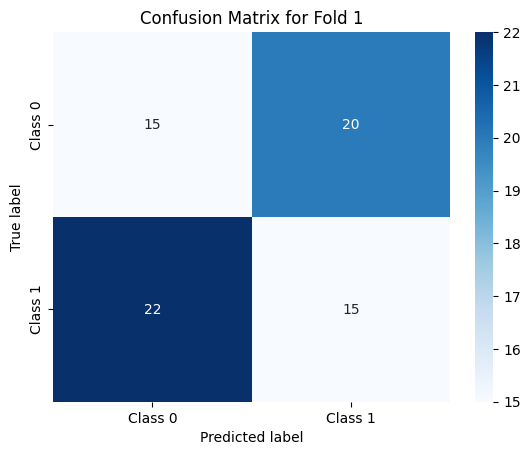

<ipython-input-6-dc64dee5606b>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch: 22 Loss: 0.00003
Fold 2 Test set accuracy: 0.56

Classification Report for Fold 2:
              precision    recall  f1-score   support

         0.0       0.53      0.49      0.51        37
         1.0       0.50      0.54      0.52        35

    accuracy                           0.51        72
   macro avg       0.51      0.51      0.51        72
weighted avg       0.52      0.51      0.51        72



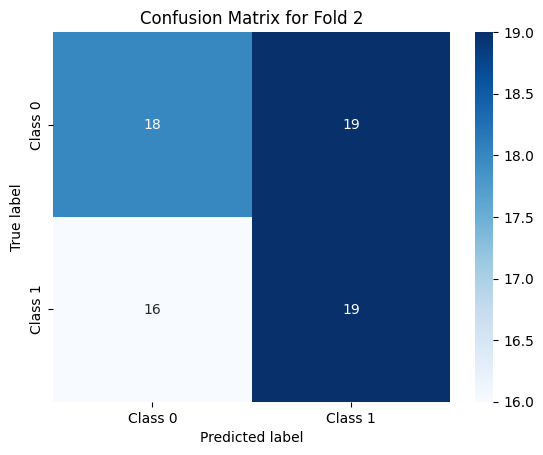

<ipython-input-6-dc64dee5606b>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch: 24 Loss: 0.00002
Fold 3 Test set accuracy: 0.32

Classification Report for Fold 3:
              precision    recall  f1-score   support

         0.0       0.46      0.56      0.51        32
         1.0       0.58      0.47      0.52        40

    accuracy                           0.51        72
   macro avg       0.52      0.52      0.51        72
weighted avg       0.52      0.51      0.51        72



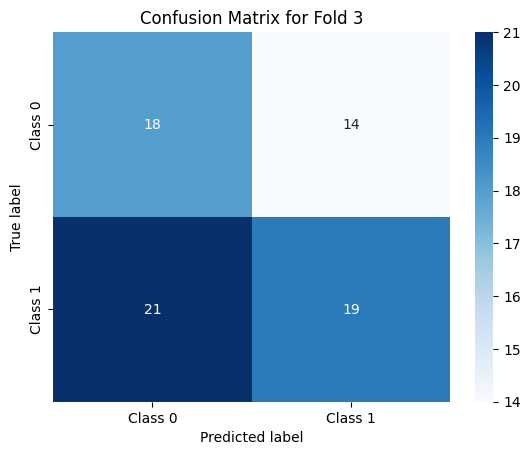

<ipython-input-6-dc64dee5606b>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch: 22 Loss: 0.00000
Fold 4 Test set accuracy: 0.50

Classification Report for Fold 4:
              precision    recall  f1-score   support

         0.0       0.46      0.47      0.47        36
         1.0       0.46      0.44      0.45        36

    accuracy                           0.46        72
   macro avg       0.46      0.46      0.46        72
weighted avg       0.46      0.46      0.46        72



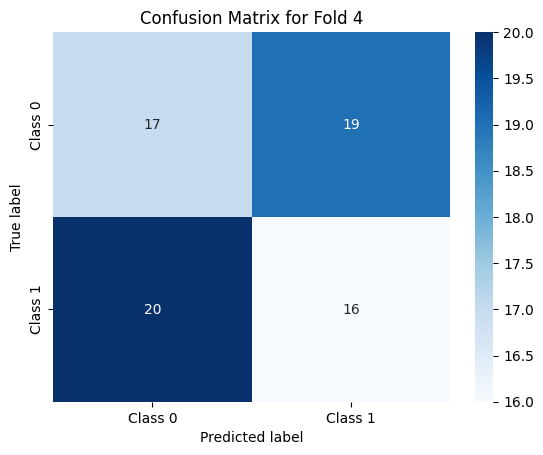

<ipython-input-6-dc64dee5606b>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch: 21 Loss: 0.00001
Fold 5 Test set accuracy: 0.60

Classification Report for Fold 5:
              precision    recall  f1-score   support

         0.0       0.53      0.40      0.46        40
         1.0       0.43      0.56      0.49        32

    accuracy                           0.47        72
   macro avg       0.48      0.48      0.47        72
weighted avg       0.49      0.47      0.47        72



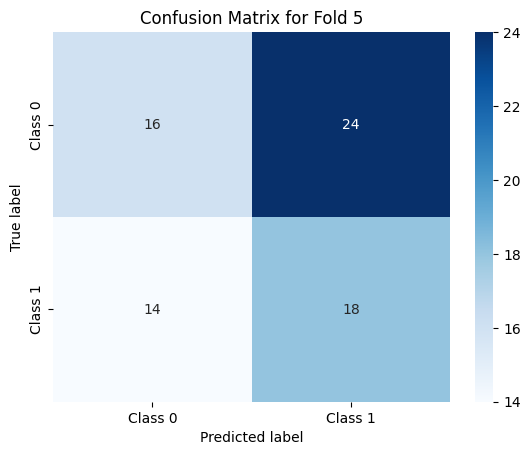


-------------------------------------------------
Average Accuracy using Logistic Regression Model: 0.46
-------------------------------------------------



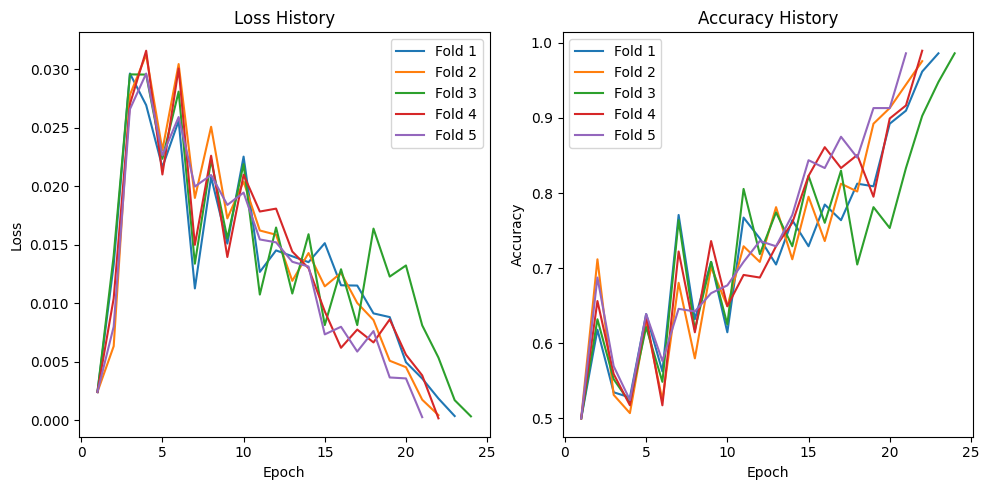

In [11]:
def calculate_average_accuracy(accuracies):
    total_accuracy = sum(accuracies)
    average_accuracy = total_accuracy / len(accuracies)
    return average_accuracy

accuracies, loss_history, accuracy_history = train_logistic_regression(X, Y)
average_accuracy = calculate_average_accuracy(accuracies)
print()
print("-------------------------------------------------")
print(f"Average Accuracy using Logistic Regression Model: {average_accuracy:.2f}")
print("-------------------------------------------------")
print()


loss_accuracy_history_graph(loss_histories, accuracy_histories)

#---------Logistic Regression Model with Feature Extraction---------

In [12]:
mat_contents = sio.loadmat('WLDataCW.mat')
data = mat_contents['data']
label = mat_contents['label']
accuracies = []
accuracy_histories = []
loss_histories = []

In [13]:

def extract_features(data, fs=256):
    n_channels, n_datapoints, n_samples = data.shape

    # Number of frequency bands
    n_bands = 5
    band_limits = np.array([
        (0.5, 4),
        (4, 8),
        (8, 12),
        (12, 30),
        (30, fs / 2)
    ])

    features = np.zeros((n_samples, n_channels * n_bands))

    for sample_idx in range(n_samples):
        sample_data = data[:, :, sample_idx]  # Get data for a single sample

        for channel_idx in range(n_channels):
            channel_data = sample_data[channel_idx, :n_datapoints // 2]  # Take first second
            fft_data = fft(channel_data)  # Perform FFT
            power_spectrum = np.abs(fft_data[:n_datapoints // 2])**2  # Calculate power spectrum

            # Average power within each frequency band
            for band_idx in range(n_bands):
                low, high = band_limits[band_idx]
                band_indices = (fs / n_datapoints * np.arange(len(power_spectrum)))
                band_indices = (band_indices >= low) & (band_indices <= high)
                band_power = np.mean(power_spectrum[band_indices])
                features[sample_idx, channel_idx * n_bands + band_idx] = band_power

    return features

features = extract_features(data)

featured_data = features.T
print("Data shape after feature extraction process: ", featured_data.shape)

Data shape after feature extraction process:  (310, 360)


Featured Data and Labels shuffling

In [14]:

label_reversed = np.flip(np.copy(label), axis=1)
label_reshaped = np.concatenate((label_reversed, label), axis=0)

shuffled = np.arange(featured_data.shape[1])
np.random.shuffle(shuffled)

data_shuffled = featured_data[:, shuffled]
labels_shuffled = label_reshaped[:, shuffled]

X = np.array_split(data_shuffled, 5, axis=1)
Y = np.array_split(labels_shuffled, 5, axis=1)
X = np.array(X, dtype=np.float64)
Y = np.array(Y, dtype=np.float64)

# Now 'sets' is a list of 5 numpy arrays, each with shape (310, 72)
for i, X_set in enumerate(X):
    print(f"X_train Set {i+1} shape: {X_set.shape}")
print()
for i, Y_set in enumerate(Y):
    print(f"Y_train Set {i+1} shape: {Y_set.shape}")

X_train Set 1 shape: (310, 72)
X_train Set 2 shape: (310, 72)
X_train Set 3 shape: (310, 72)
X_train Set 4 shape: (310, 72)
X_train Set 5 shape: (310, 72)

Y_train Set 1 shape: (2, 72)
Y_train Set 2 shape: (2, 72)
Y_train Set 3 shape: (2, 72)
Y_train Set 4 shape: (2, 72)
Y_train Set 5 shape: (2, 72)


Training and accuracy calculation for the featured data sets

<ipython-input-6-dc64dee5606b>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch: 2999 Loss: 0.00250
Fold 1 Test set accuracy: 0.89

Classification Report for Fold 1:
              precision    recall  f1-score   support

         0.0       0.81      0.97      0.88        31
         1.0       0.97      0.83      0.89        41

    accuracy                           0.89        72
   macro avg       0.89      0.90      0.89        72
weighted avg       0.90      0.89      0.89        72



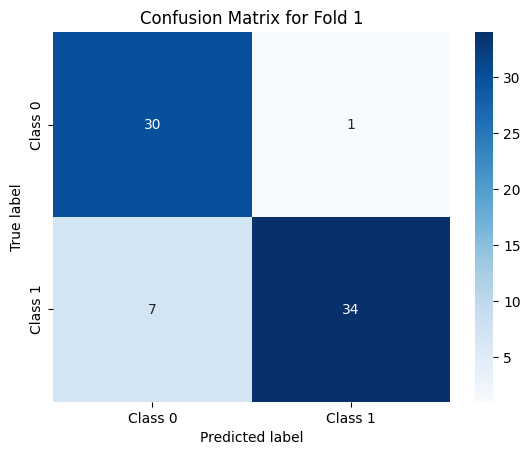

<ipython-input-6-dc64dee5606b>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch: 2999 Loss: 0.00725
Fold 2 Test set accuracy: 0.81

Classification Report for Fold 2:
              precision    recall  f1-score   support

         0.0       0.94      0.71      0.81        41
         1.0       0.71      0.94      0.81        31

    accuracy                           0.81        72
   macro avg       0.82      0.82      0.81        72
weighted avg       0.84      0.81      0.81        72



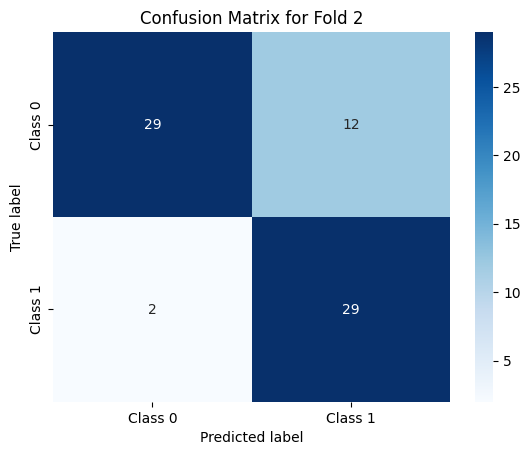

<ipython-input-6-dc64dee5606b>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch: 2999 Loss: 0.00125
Fold 3 Test set accuracy: 0.86

Classification Report for Fold 3:
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87        37
         1.0       0.88      0.83      0.85        35

    accuracy                           0.86        72
   macro avg       0.86      0.86      0.86        72
weighted avg       0.86      0.86      0.86        72



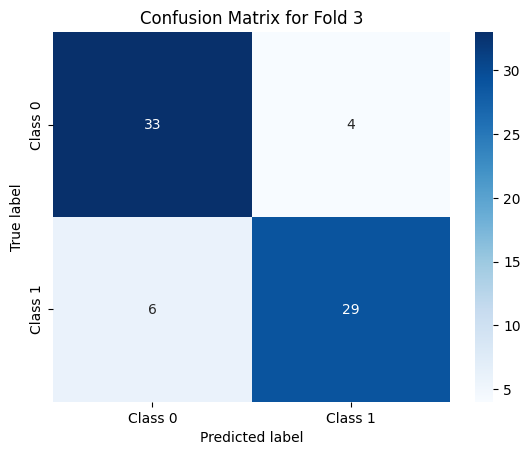

<ipython-input-6-dc64dee5606b>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch: 2999 Loss: 0.00650
Fold 4 Test set accuracy: 0.86

Classification Report for Fold 4:
              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83        35
         1.0       0.79      1.00      0.88        37

    accuracy                           0.86        72
   macro avg       0.89      0.86      0.86        72
weighted avg       0.89      0.86      0.86        72



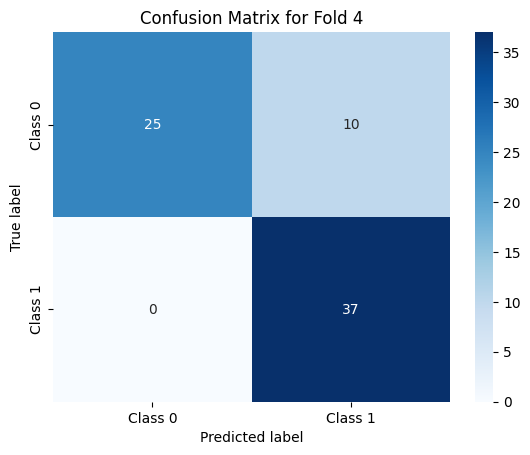

<ipython-input-6-dc64dee5606b>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch: 2999 Loss: 0.00175
Fold 5 Test set accuracy: 0.90

Classification Report for Fold 5:
              precision    recall  f1-score   support

         0.0       0.97      0.83      0.90        36
         1.0       0.85      0.97      0.91        36

    accuracy                           0.90        72
   macro avg       0.91      0.90      0.90        72
weighted avg       0.91      0.90      0.90        72



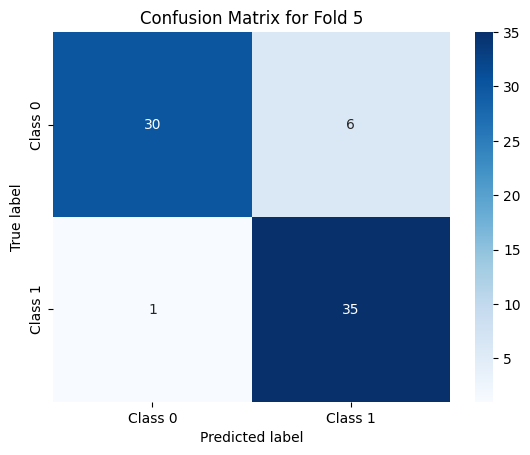


-------------------------------------------------------------------------
Average Accuracy using Logistic Regression model with feature extraction: 0.86
-------------------------------------------------------------------------



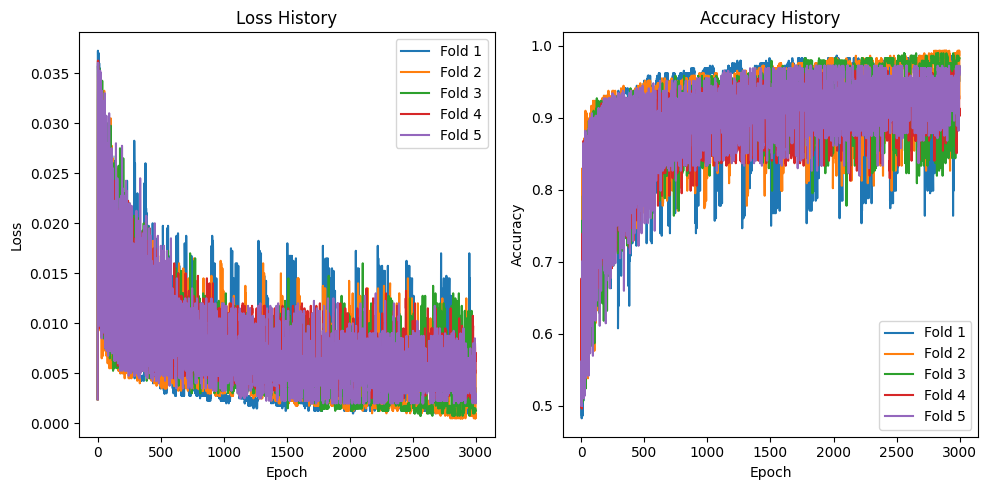

In [15]:
accuracies, loss_history, accuracy_history = train_logistic_regression(X, Y)
average_accuracy_fe = calculate_average_accuracy(accuracies)
print()
print("-------------------------------------------------------------------------")
print(f"Average Accuracy using Logistic Regression model with feature extraction: {average_accuracy_fe:.2f}")
print("-------------------------------------------------------------------------")
print()
loss_accuracy_history_graph(loss_history, accuracy_history)

#---------CNN Model---------

Classification using a simple CNN model using keras.

https://keras.io/guides/sequential_model/

Number of classes = 2.

Input shape = 512 * 62 for each sample.

activation function = relu, sigmoid

loss function = Binary cross entropy loss

In [16]:
mat_contents = sio.loadmat('WLDataCW.mat')
data = mat_contents['data']
label = mat_contents['label']

In [17]:
def cnn_eeg():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(6, kernel_size=5, activation='relu', input_shape=(512, 62, 1)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(16, kernel_size=5, activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=2))

    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(1200, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = cnn_eeg()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 508, 58, 6)        156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 254, 29, 6)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 25, 16)       2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 125, 12, 16)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 24000)             0         
                                                                 
 dense (Dense)               (None, 1200)              2

In [18]:
# Initializations
kf = KFold(n_splits=5, shuffle=True)
fold_scores = []

label_eeg = label.T
data_eeg = data.transpose(2,1,0)

print("X shape: ", data_eeg.shape)
print("Y shape: ", label_eeg.shape)

accuracies = []
histories = []
accuracy_histories = []
loss_histories = []

X shape:  (360, 512, 62)
Y shape:  (360, 1)


Training Loop

Fold 1:
Epoch 1/10
9/9 [==============================] - 13s 1s/step - loss: 60.6859 - accuracy: 0.5069 - val_loss: 1.1310 - val_accuracy: 0.6389
Epoch 2/10
9/9 [==============================] - 11s 1s/step - loss: 3.0352 - accuracy: 0.5451 - val_loss: 1.0079 - val_accuracy: 0.6111
Epoch 3/10
9/9 [==============================] - 11s 1s/step - loss: 0.7563 - accuracy: 0.6111 - val_loss: 0.5244 - val_accuracy: 0.7778
Epoch 4/10
9/9 [==============================] - 11s 1s/step - loss: 0.4588 - accuracy: 0.8472 - val_loss: 0.6842 - val_accuracy: 0.6389
Epoch 5/10
9/9 [==============================] - 10s 1s/step - loss: 0.3186 - accuracy: 0.9340 - val_loss: 0.5193 - val_accuracy: 0.8611
Epoch 6/10
9/9 [==============================] - 11s 1s/step - loss: 0.2619 - accuracy: 0.9618 - val_loss: 0.5395 - val_accuracy: 0.8056
Epoch 7/10
9/9 [==============================] - 13s 1s/step - loss: 0.1427 - accuracy: 0.9757 - val_loss: 0.5824 - val_accuracy: 0.8056
Epoch 8/10
9/9 [=========

3/3 [==============================] - 1s 139ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.93        42
           1       0.85      0.97      0.91        30

    accuracy                           0.92        72
   macro avg       0.91      0.92      0.92        72
weighted avg       0.92      0.92      0.92        72

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 508, 58, 6)        156       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 254, 29, 6)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 250, 25, 16)       2416      
                                               

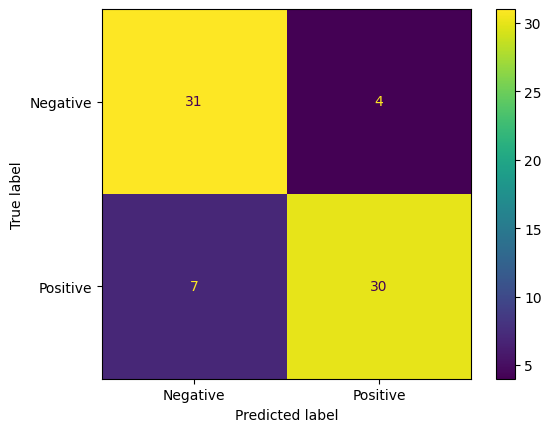

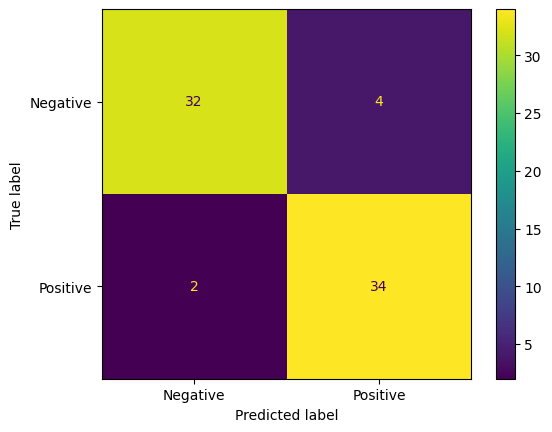

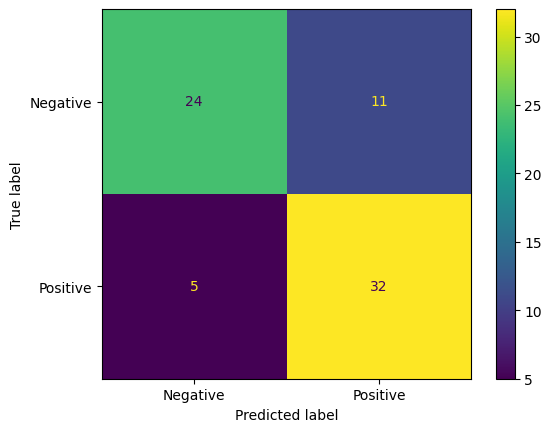

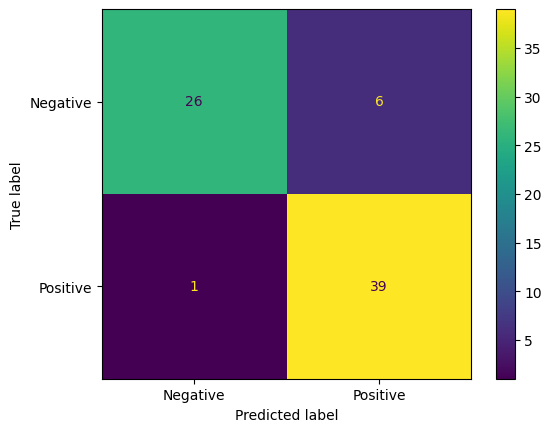

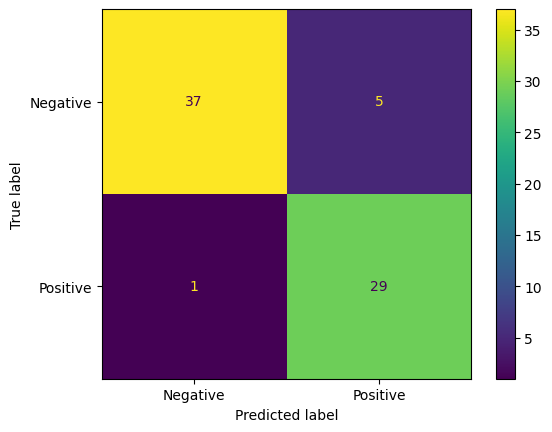

In [19]:
for fold, (train_index, val_index) in enumerate(kf.split(data_eeg), 1):
    print(f"Fold {fold}:")
    X_train, X_test = data_eeg[train_index], data_eeg[val_index]
    y_train, y_test = label_eeg[train_index], label_eeg[val_index]
    model = cnn_eeg()
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
    test_loss, test_acc = model.evaluate(X_test, y_test)
    accuracies.append(test_acc)
    histories.append(history.history)

    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    # Calculate classification report
    report = classification_report(y_test, y_pred_classes)
    print("Classification Report:")
    print(report)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    # Display confusion matrix
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    display.plot()

# model.summary()
average_accuracy_cnn = np.mean(accuracies)
print()
print("--------------------------------")
print("Average Accuracy with CNN model:", round(average_accuracy_cnn, 2))
print("--------------------------------")
print()

Plot Graphs
1. Loss vs Epoch
2. Accuracy vs Epoch

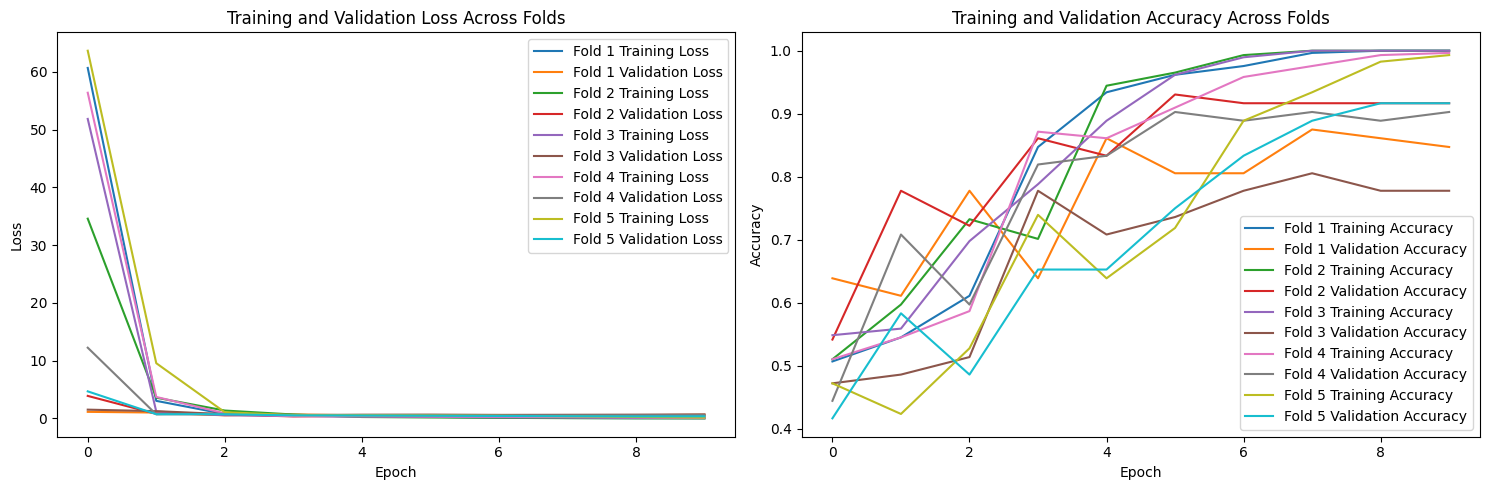

In [20]:

def plot_history(histories):
    plt.figure(figsize=(15, 5))
    # Plot for loss
    plt.subplot(1, 2, 1)
    for fold, history in enumerate(histories, 1):
        plt.plot(history['loss'], label=f'Fold {fold} Training Loss')
        plt.plot(history['val_loss'], label=f'Fold {fold} Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Across Folds')
    plt.legend()

    # Plot for accuracy
    plt.subplot(1, 2, 2)
    for fold, history in enumerate(histories, 1):
        plt.plot(history['accuracy'], label=f'Fold {fold} Training Accuracy')
        plt.plot(history['val_accuracy'], label=f'Fold {fold} Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Across Folds')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(histories)

#---------Accuracy comparisons---------

Plot Graph using all the three accuracies.

1. Average Accuracy using Logistic Regression Model
2. Average Accuracy using Logistic Regression model with feature extraction
3. Average Accuracy with CNN model

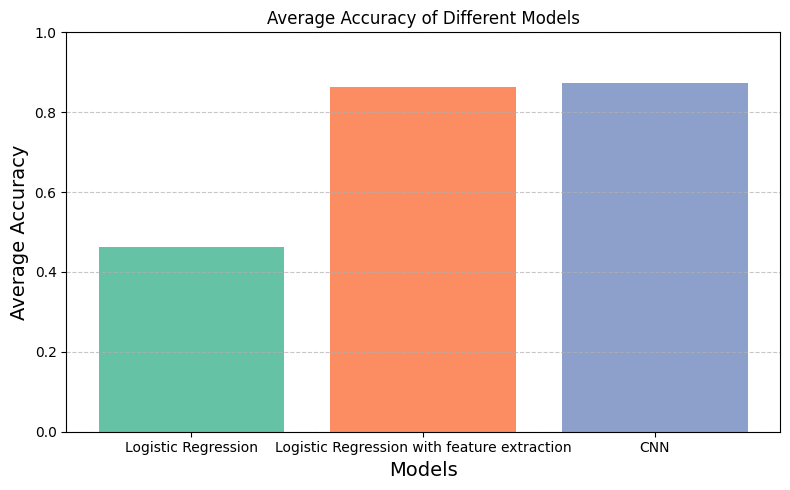

In [21]:

# Average accuracies
models = ['Logistic Regression', 'Logistic Regression with feature extraction', 'CNN']
accuracies = [average_accuracy, average_accuracy_fe, average_accuracy_cnn]

# Color codes for x-axis labels
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# Plotting the bar graph
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=colors)

plt.xlabel('Models', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)
plt.title('Average Accuracy of Different Models')

# Displaying the values on top of each bar
for bar, accuracy, color in zip(bars, accuracies, colors):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{accuracy:.2f}', ha='center', color=color)

plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for accuracy
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

